# Step 1: Importing Libraries

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf

from  tensorflow.keras.utils import to_categorical 
from  tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from  tensorflow.keras.utils import to_categorical 

from  tensorflow.keras.optimizers import Adam
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from  tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Import Data

In [65]:
import os
import pandas as pd

train_dir = 'isic2019/train'
test_dir = 'isic2019/test'

train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
        
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

In [66]:
labels = os.listdir(train_dir)


label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

# Exploratory Data Analysis (EDA)

In [67]:
class_counts = df['label'].value_counts().sort_index()

print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [68]:
max_images_per_class = 2500

df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

# Oversampling
**To overcome class imbalace**

In [119]:
import multiprocessing

max_workers = multiprocessing.cpu_count()
max_workers

In [ ]:
import concurrent.futures

def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((32,32)))

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

df['image'] = image_arrays
del image_arrays

In [ ]:
df.head()

In [ ]:
class_counts = df['label'].value_counts().sort_index()

print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

for class_label in df['label'].unique():
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    num_images_needed = max_images_per_class - len(image_arrays)
    
    if num_images_needed > 0:
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        for image_array in selected_images:
            image_tensor = np.expand_dims(image_array, axis=0)
            
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
    
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
class_counts = df['label'].value_counts().sort_index()

print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

In [ ]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [ ]:
features.head()

In [ ]:
target.head()

In [ ]:
print(target.shape,features.shape)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))

In [ ]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

# Model Training

In [124]:
vgg=tf.keras.applications.VGG19(input_shape=(32,32,3),weights='imagenet', include_top=False)
for i in vgg.layers:
    i.trainable = False

In [155]:
model = tf.keras.models.Sequential([
    vgg,
    tf.keras.layers.Conv2D(128, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(9, activation = 'softmax')
])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 128)         589952    
                                                                 
 activation_5 (Activation)   (None, 1, 1, 128)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 1, 64)          73792     
                                                                 
 activation_6 (Activation)   (None, 1, 1, 64)          0         
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 32)          18464     
                                                                 
 activation_7 (Activation)   (None, 1, 1, 32)         

In [156]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)


In [157]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size = 32,
                    epochs = 100,
                    callbacks=[callback])

Epoch 1/100


2023-03-20 14:31:40.865861: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


234/235 [============================>.] - ETA: 0s - loss: 1.0928 - accuracy: 0.5948
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 8s 26ms/step - loss: 1.0924 - accuracy: 0.5949 - val_loss: 1.5067 - val_accuracy: 0.5839
Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7388
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 6s 24ms/step - loss: 0.7078 - accuracy: 0.7388 - val_loss: 0.7414 - val_accuracy: 0.7690
Epoch 3/100
234/235 [============================>.] - ETA: 0s - loss: 0.5342 - accuracy: 0.8052
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 6s 24ms/step - loss: 0.5342 - accuracy: 0.8051 - val_loss: 0.5327 - val_accuracy: 0.7905
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.8494
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 5s 23ms/step - loss: 0.4251 -

# Plot Accuracy and Loss

## Accuracy (training vs validation dataset)

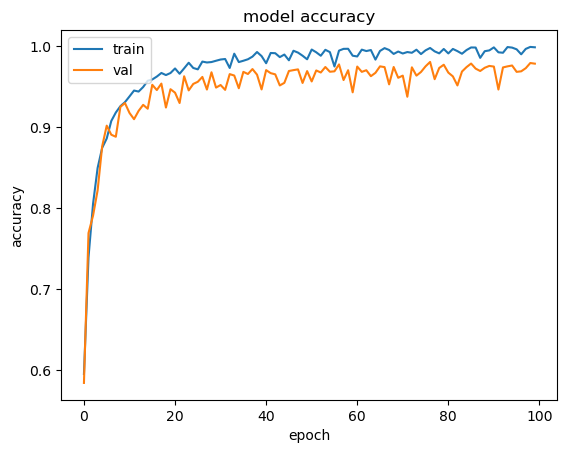

In [158]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Loss (training vs validation dataset)

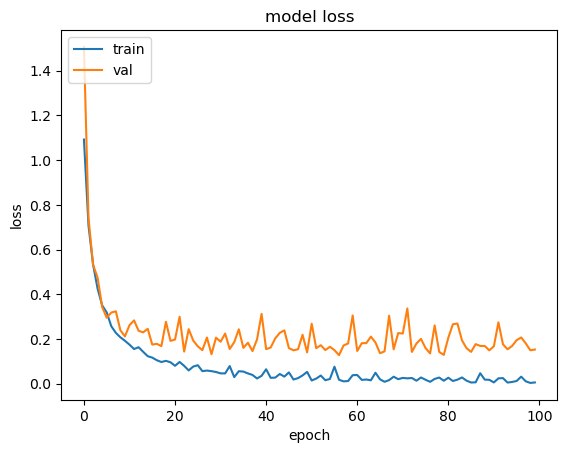

In [159]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [160]:
model.load_weights('best_model.h5')


# Model Testing

In [161]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 3s - loss: 0.1915 - accuracy: 0.9729 - 3s/epoch - 9ms/step


In [162]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

In [163]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test) 
y_pred_labels = np.argmax(y_pred_ohe, axis=1) 

confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)

294/294 [==============================] - 3s 8ms/step


In [164]:
class_labels = ['akiec','bcc','bkl','df','nv','vasc','mel']
report = sklearn.metrics.classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

       akiec       0.99      1.00      1.00      1359
         bcc       0.99      1.00      0.99      1318
         bkl       0.93      0.99      0.96      1262
          df       1.00      1.00      1.00      1351
          nv       0.98      0.84      0.91      1374
        vasc       1.00      1.00      1.00      1358
         mel       0.93      0.99      0.96      1365

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387



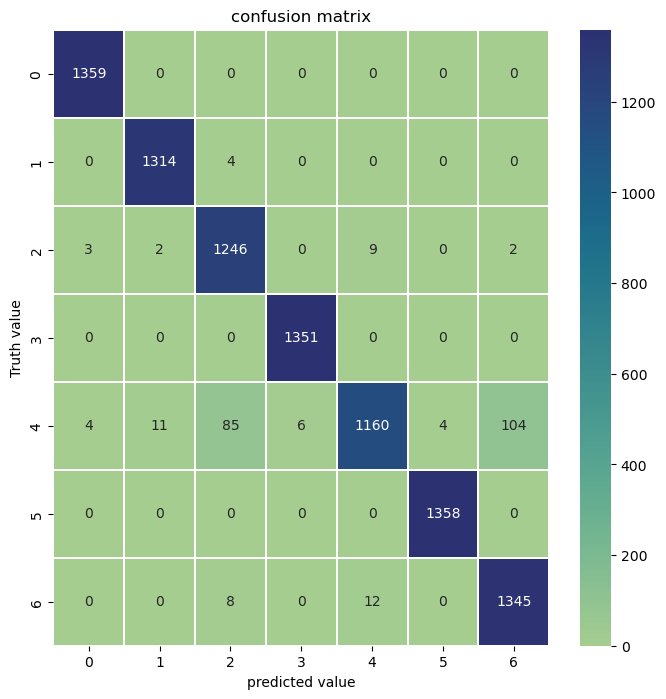

[[1359    0    0    0    0    0    0]
 [   0 1314    4    0    0    0    0]
 [   3    2 1246    0    9    0    2]
 [   0    0    0 1351    0    0    0]
 [   4   11   85    6 1160    4  104]
 [   0    0    0    0    0 1358    0]
 [   0    0    8    0   12    0 1345]]


In [165]:
cm = sklearn.metrics.confusion_matrix(Y_test, y_pred_labels)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(Y_test, y_pred_labels))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


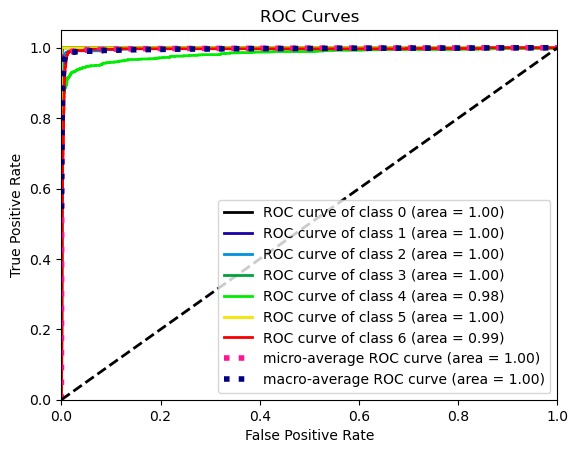

In [166]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve(Y_test, y_pred_ohe)
plt.show()

# Tesing model on dataset

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

In [3]:
import os
import pandas as pd

train_dir = 'isic2019/val'

In [4]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5', compile=False)

In [5]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 128)         589952    
_________________________________________________________________
activation_5 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 64)          73792     
_________________________________________________________________
activation_6 (Activation)    (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 32)          18464     
_________________________________________________________________
activation_7 (Activation)    (None, 1, 1, 32)         

In [6]:

data = np.zeros([1, 32, 32, 3],dtype=np.float32)


In [12]:
img_array = []
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        img = cv2.imread(image_path)
        resized_img = cv2.resize(img, (32,32))
        img_array.append(resized_img)

In [16]:
label_array = []
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        label_array.append(directory)

In [46]:
labels_array = []
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        labels_array.append(label)

In [15]:
len(img_array)

1910

In [17]:
label_array

['Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic keratosis',
 'Actinic 

In [13]:
x = np.array(img_array)

In [14]:
x

array([[[[141, 131, 161],
         [135, 134, 163],
         [136, 130, 161],
         ...,
         [102,  78, 110],
         [106,  78, 111],
         [ 99,  73, 104]],

        [[138, 129, 161],
         [121, 119, 156],
         [141, 135, 165],
         ...,
         [ 88,  67, 103],
         [ 94,  68, 104],
         [ 98,  73, 102]],

        [[136, 131, 163],
         [133, 127, 162],
         [144, 138, 167],
         ...,
         [ 84,  86, 109],
         [ 82,  62,  97],
         [ 92,  67,  99]],

        ...,

        [[ 71,  58, 107],
         [ 71,  61, 112],
         [ 95,  81, 121],
         ...,
         [111,  83, 134],
         [112,  85, 137],
         [125, 100, 138]],

        [[ 68,  52, 100],
         [ 71,  56, 104],
         [ 80,  64, 112],
         ...,
         [117,  89, 135],
         [101,  82, 130],
         [114,  93, 132]],

        [[ 69,  54, 100],
         [ 63,  51,  98],
         [ 78,  64, 112],
         ...,
         [118,  91, 136],
        

In [21]:
x = (x-np.mean(x))/np.std(x)


In [22]:
y_pred_ohe = model.predict(x) 
y_pred_labels = np.argmax(y_pred_ohe, axis=1) 

In [32]:
y_pred_labels[0]

1

In [47]:
y_actual_labels = np.array(labels_array)

In [36]:
classes = {4: ('nv', ' Melanocytic nevus'), 6: ('mel', 'Melanoma'), 2 :('bkl', 'Benign keratosis'), 1:('bcc' , ' Basal cell carcinoma'), 5: ('vasc', 'Vascular lesion'), 0: ('akiec', 'Actinic keratosis'),  3: ('df', 'Dermatofibroma')}

In [37]:
def getcode(n) : 
    for x , y in classes.items() : 
        if n == x : 
            return y

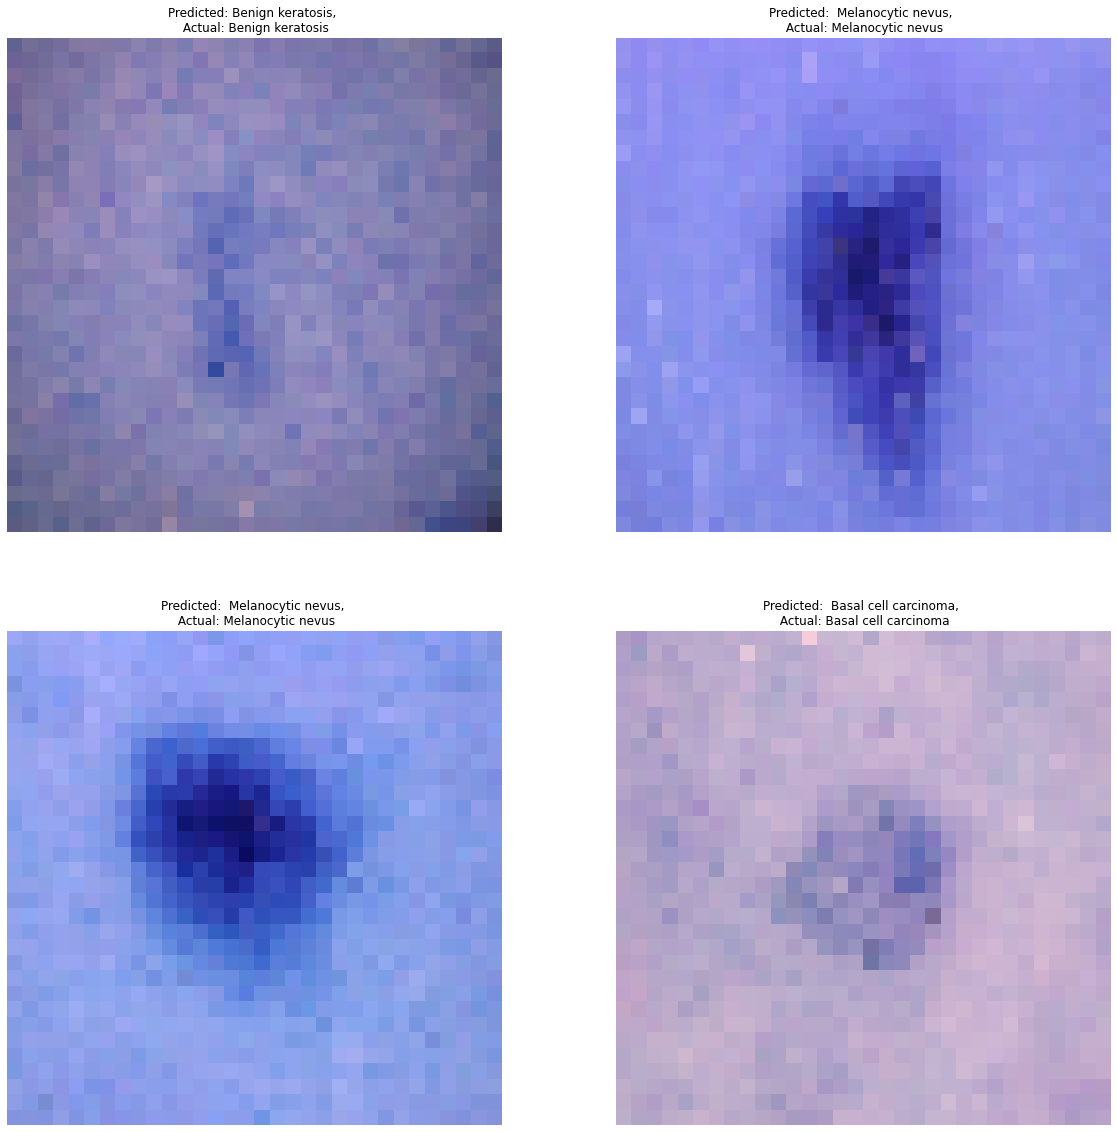

In [56]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(img_array),4))) : 
    plt.subplot(2,2,n+1)
    plt.imshow(img_array[i])    
    plt.axis('off')
    plt.title(f"Predicted: {getcode(y_pred_labels[i])[1]}, \n Actual: {label_array[i]}" )